In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)
#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    batch_size = 28,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

import tensorflow.keras.backend as K
@tf.function
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

@tf.function
def soft_acc_multi_output(y_true, y_pred):
    return K.mean(K.all(K.equal(K.cast(K.round(y_true),'int32'), K.cast(K.round(y_pred),'int32')),axis=1))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [4]:
base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
location = Dense(1, activation="linear")(x)
# pass "location" linearly to next layer for addition
# force identity kernel but with variable weight
preds = Dense(4, activation="sigmoid", kernel_initializer=keras.initializers.Constant(value=1),
              kernel_constraint= tf.keras.constraints.MinMaxNorm(min_value=1, max_value=1, rate=1.0, axis=0))(location)

model = Model(inputs=base_model.input, outputs=preds, name = "intermediate")
model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=[soft_acc_multi_output])

early_stopping = EarlyStopping(monitor='val_loss', patience=14,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

history = model.fit_generator(generator=train_set,
                    epochs=25,
                    verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [early_stopping, reduce_lr_plateau]
                    )

In [5]:
model.trainable = True
for layer in model.layers[:70]:
    layer.trainable = False
for layer in model.layers[70:]:
    layer.trainable = True

    
validation_set.reset()
train_set.reset()
    
model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output], name = r'order-logit')
logdir_name = r".\tfb\logs\densenet_ordered_logit\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.5)

history_fine = model.fit_generator(generator=train_set,
                    epochs=100+history.epoch[-1],
                    validation_data=validation_set,
                    initial_epoch = history.epoch[-1],
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )

Epoch 15/114
16/16 [==============================] - 15s 932ms/step - loss: 0.7443 - soft_acc_multi_output: 0.2912 - val_loss: 0.9396 - val_soft_acc_multi_output: 0.2500
Epoch 16/114
16/16 [==============================] - 12s 759ms/step - loss: 0.6439 - soft_acc_multi_output: 0.3236 - val_loss: 0.8342 - val_soft_acc_multi_output: 0.2143
Epoch 17/114
16/16 [==============================] - 12s 746ms/step - loss: 0.5726 - soft_acc_multi_output: 0.3356 - val_loss: 5.1983 - val_soft_acc_multi_output: 0.1429
Epoch 18/114
16/16 [==============================] - 12s 749ms/step - loss: 0.5503 - soft_acc_multi_output: 0.3353 - val_loss: 4.4382 - val_soft_acc_multi_output: 0.2500
Epoch 19/114
16/16 [==============================] - 12s 753ms/step - loss: 0.5398 - soft_acc_multi_output: 0.3440 - val_loss: 8.2570 - val_soft_acc_multi_output: 0.1429
Epoch 20/114
16/16 [==============================] - 12s 763ms/step - loss: 0.5418 - soft_acc_multi_output: 0.3552 - val_loss: 8.2584 - val_soft

In [7]:
for layer in model.layers[:-12]:
    layer.trainable = False
for layer in model.layers[-12:]:
    layer.trainable = True

    
validation_set.reset()
train_set.reset()
    
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0005), loss='binary_crossentropy', metrics=[soft_acc_multi_output], name = r'order-logit')
early_stopping = EarlyStopping(monitor='val_loss', patience=14,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.5)

history_fine2 = model.fit_generator(generator=train_set,
                    epochs=25+ history_fine.epoch[-1],
#                     verbose=2,
                    validation_data=validation_set,
#                     validation_freq=2,
                    initial_epoch = history_fine.epoch[-1],
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )

Epoch 75/99
16/16 [==============================] - 8s 506ms/step - loss: 0.3889 - soft_acc_multi_output: 0.4800 - val_loss: 0.4942 - val_soft_acc_multi_output: 0.4286
Epoch 76/99
16/16 [==============================] - 7s 465ms/step - loss: 0.3672 - soft_acc_multi_output: 0.4829 - val_loss: 0.4895 - val_soft_acc_multi_output: 0.3929
Epoch 77/99
16/16 [==============================] - 7s 458ms/step - loss: 0.3612 - soft_acc_multi_output: 0.4875 - val_loss: 0.4905 - val_soft_acc_multi_output: 0.3750
Epoch 78/99
16/16 [==============================] - 8s 479ms/step - loss: 0.3597 - soft_acc_multi_output: 0.5163 - val_loss: 0.4821 - val_soft_acc_multi_output: 0.3571
Epoch 79/99
16/16 [==============================] - 7s 469ms/step - loss: 0.3608 - soft_acc_multi_output: 0.5125 - val_loss: 0.4818 - val_soft_acc_multi_output: 0.3571
Epoch 80/99
16/16 [==============================] - 7s 464ms/step - loss: 0.3605 - soft_acc_multi_output: 0.5129 - val_loss: 0.4939 - val_soft_acc_multi_o

In [12]:
model.layers[-1].variables

[<tf.Variable 'dense_1/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[0.9999999, 0.9999999, 0.9999999, 0.9999999]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.45868656,  0.37378472, -0.39208117, -0.46056896], dtype=float32)>]

In [13]:
model.save(filepath ="./saved_models/my_effnet/1/", save_format='h5')
# warning: tf.keras.Model.save() method does not support saving optimizers from tf.train

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_models/my_effnet/1/assets


In [8]:
model = tf.keras.models.load_model(filepath ="./saved_models/my_effnet/1/",custom_objects={'soft_acc_multi_output':soft_acc_multi_output}, compile=False)
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0005), loss='binary_crossentropy',metrics=[soft_acc_multi_output])
# save model format losses optimizer state due to unable to load custom metrics

tf.Tensor(0.42857143, shape=(), dtype=float32)


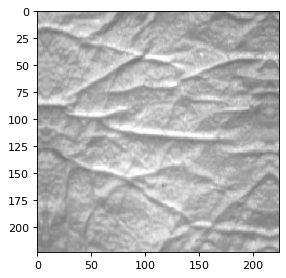

true label: [1 1 1 1]; rounded pred: [0.8149192  0.8017701  0.65283597 0.63715583]; Correct: True


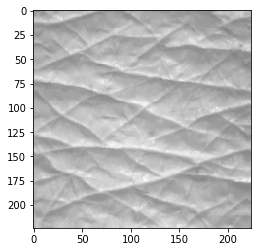

true label: [1 0 0 0]; rounded pred: [0.5438309  0.5227026  0.33737975 0.32224345]; Correct: False


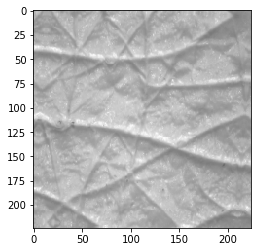

true label: [1 1 0 0]; rounded pred: [0.70195484 0.6838933  0.5014641  0.48434728]; Correct: False


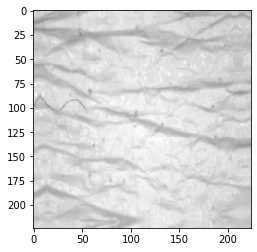

true label: [1 1 1 0]; rounded pred: [0.82793796 0.81550443 0.67267644 0.6574222 ]; Correct: False


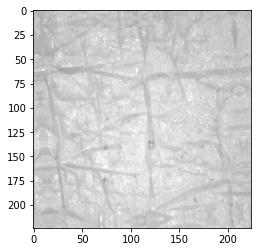

true label: [1 1 1 1]; rounded pred: [0.7304426  0.71340257 0.5364605  0.5193937 ]; Correct: True


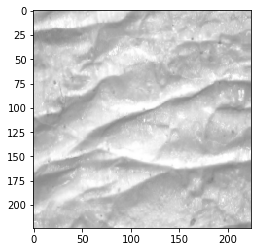

true label: [1 1 1 0]; rounded pred: [0.9742499  0.97203207 0.9417207  0.9378462 ]; Correct: False


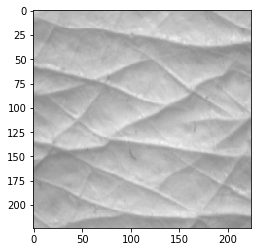

true label: [1 1 0 0]; rounded pred: [0.5673021  0.54635406 0.35895202 0.34334943]; Correct: True


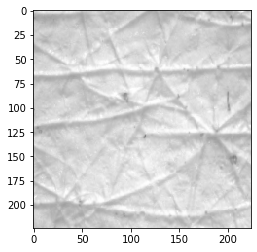

true label: [1 1 1 0]; rounded pred: [0.80892324 0.7954551  0.6438837  0.62802964]; Correct: False


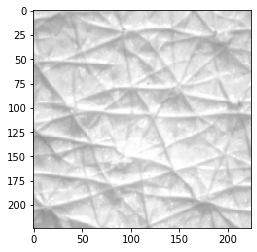

true label: [1 1 0 0]; rounded pred: [0.43087614 0.41019017 0.24433738 0.23191437]; Correct: False


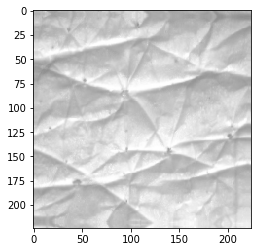

true label: [1 0 0 0]; rounded pred: [0.58711785 0.56639594 0.37784523 0.361885  ]; Correct: False


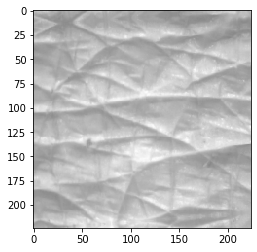

true label: [1 1 0 0]; rounded pred: [0.62265205 0.60250616 0.41339517 0.39689124]; Correct: True


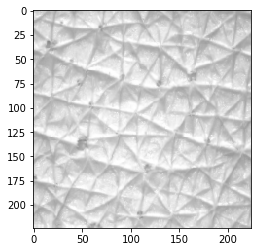

true label: [0 0 0 0]; rounded pred: [0.21936515 0.20517287 0.10715491 0.10077658]; Correct: True


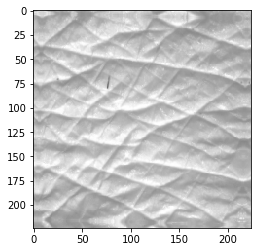

true label: [1 1 1 0]; rounded pred: [0.6768503  0.65800864 0.4721705  0.4551407 ]; Correct: False


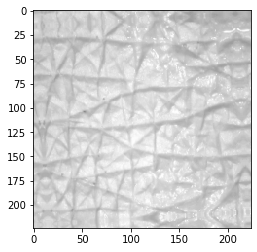

true label: [0 0 0 0]; rounded pred: [0.1617817  0.1505962  0.07615325 0.07147253]; Correct: True


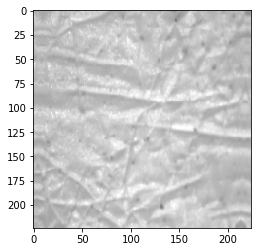

true label: [1 1 1 1]; rounded pred: [0.98514783 0.98385304 0.9659038  0.9635749 ]; Correct: True


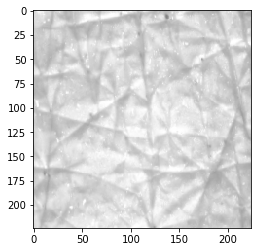

true label: [1 1 0 0]; rounded pred: [0.6670153  0.64789855 0.46106622 0.44409993]; Correct: True


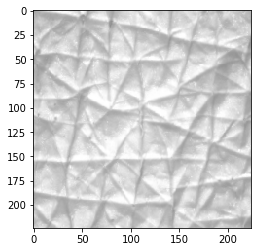

true label: [1 0 0 0]; rounded pred: [0.38801658 0.36805758 0.21308574 0.20182732]; Correct: False


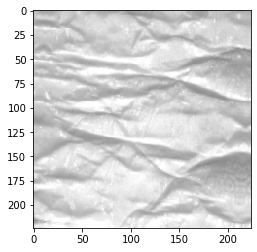

true label: [1 1 1 1]; rounded pred: [0.9612552  0.9579663  0.9137633  0.90821135]; Correct: True


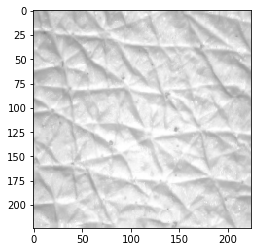

true label: [1 1 0 0]; rounded pred: [0.51047426 0.48925203 0.30813253 0.29372677]; Correct: False


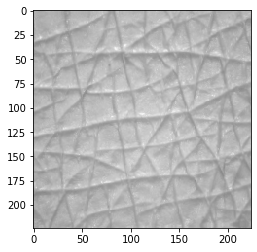

true label: [1 1 0 0]; rounded pred: [0.21664488 0.2025829  0.10563779 0.09933972]; Correct: False


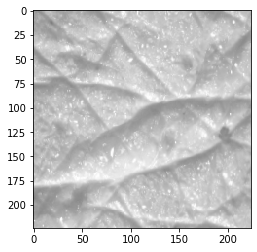

true label: [1 1 0 0]; rounded pred: [0.7453721  0.72892565 0.5555973  0.5386291 ]; Correct: False


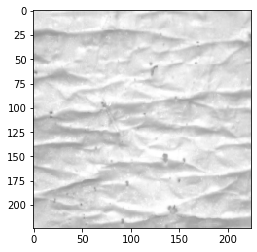

true label: [1 1 1 1]; rounded pred: [0.90001893 0.89211535 0.7935842  0.78213966]; Correct: True


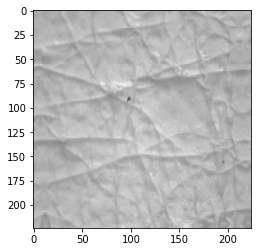

true label: [1 1 1 0]; rounded pred: [0.8079325  0.7944124  0.6424156  0.62653404]; Correct: False


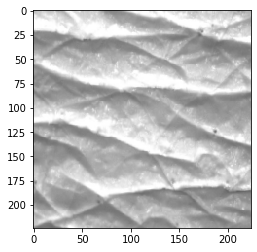

true label: [1 1 0 0]; rounded pred: [0.70758116 0.6897099  0.50822365 0.49110338]; Correct: False


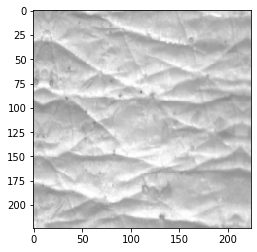

true label: [1 1 1 0]; rounded pred: [0.7983326  0.7843169  0.62834823 0.61221904]; Correct: False


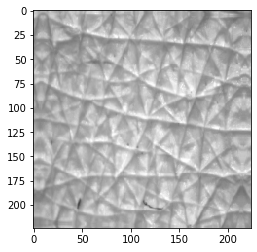

true label: [1 0 0 0]; rounded pred: [0.44659334 0.42571723 0.25631458 0.2434789 ]; Correct: False


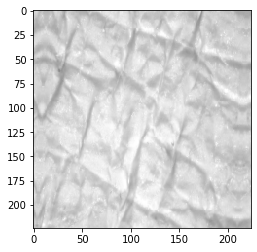

true label: [1 1 1 1]; rounded pred: [0.9988681  0.99876785 0.9973537  0.99716663]; Correct: True


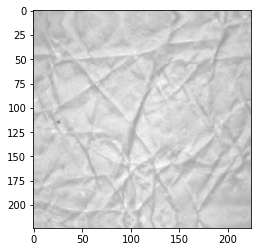

true label: [1 1 1 1]; rounded pred: [0.8976133  0.88954294 0.7892174  0.7775986 ]; Correct: True


In [11]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))}")